## GAN Condicional

### Carga de datos

In [455]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import keras
from IPython import display
#from scipy.misc import imshow
from scipy.misc.pilutil import imread
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend
from tqdm import tqdm

In [456]:
(x1, y1), (x2, y2) = cifar10.load_data()

In [457]:
images = np.concatenate((x1, x2), axis=0)
labels = np.concatenate((y1, y2), axis=0)

In [458]:
del x1, y1, x2, y2

In [459]:
print("images", len(images))
print("labels", len(labels))

X_train = np.array(images)
Y_train = np.array(labels)
print(X_train.shape)
print(Y_train.shape)

images 60000
labels 60000
(60000, 32, 32, 3)
(60000, 1)


### Analizo imágnes

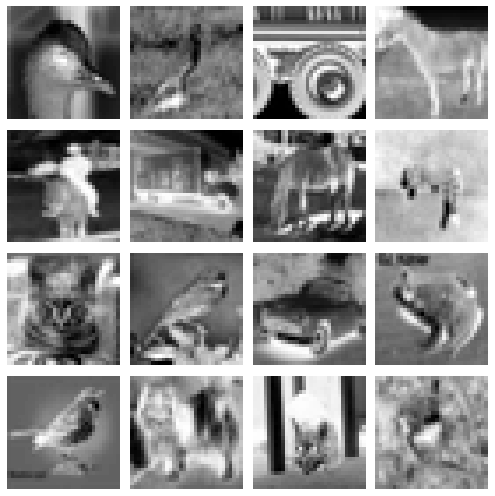

In [460]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [461]:
labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

Image index: 53134
Label index: 7
Label: Horse


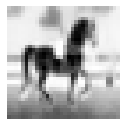

In [462]:
index = np.random.choice(X_train.shape[0],1)
print("Image index:", index[0])
print("Label index:", Y_train[index][0][0])
label_index = Y_train[index][0][0]
print("Label:", labels[label_index])
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Normalizo las imágenes

In [463]:
print(np.min(X_train), np.max(X_train))

0 255


In [464]:
x_pixels = X_train.astype('float32')
print(np.min(x_pixels), np.max(x_pixels))
x_pixels = x_pixels - 127.5
print(np.min(x_pixels), np.max(x_pixels))
x_pixels /= 127.5
print(np.min(x_pixels), np.max(x_pixels))
X_train = x_pixels

0.0 255.0
-127.5 127.5
-1.0 1.0


In [465]:
print(np.min(X_train), np.max(X_train))

-1.0 1.0


In [466]:
#y_pixels = Y_train.astype('float32')
#print(np.min(y_pixels), np.max(y_pixels))
#y_pixels = y_pixels - 4.5
#print(np.min(y_pixels), np.max(y_pixels))
#y_pixels /= 4.5
#print(np.min(y_pixels), np.max(y_pixels))
#Y_train = y_pixels

In [467]:
print(np.min(Y_train), np.max(Y_train))

0 9


In [468]:
print('Shape de X_train:', X_train.shape)
print('Cantidad de muestras:',X_train.shape[0])

Shape de X_train: (60000, 32, 32, 3)
Cantidad de muestras: 60000


In [469]:
print('Shape de Y_train:', Y_train.shape)
print('Cantidad de muestras:',Y_train.shape[0])

Shape de Y_train: (60000, 1)
Cantidad de muestras: 60000


### Settings

In [470]:
img_size = 32
noise_size = 2048
batch_size = 50
classes = 10

### Modelo para Generador

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 2048)      20480       input_102[0][0]                  
__________________________________________________________________________________________________
input_101 (InputLayer)          (None, 2048)         0                                            
__________________________________________________________________________________________________
flatten_58 (Flatten)            (None, 2048)         0           embedding_39[0][0]               
__________________________________________________________________________________________

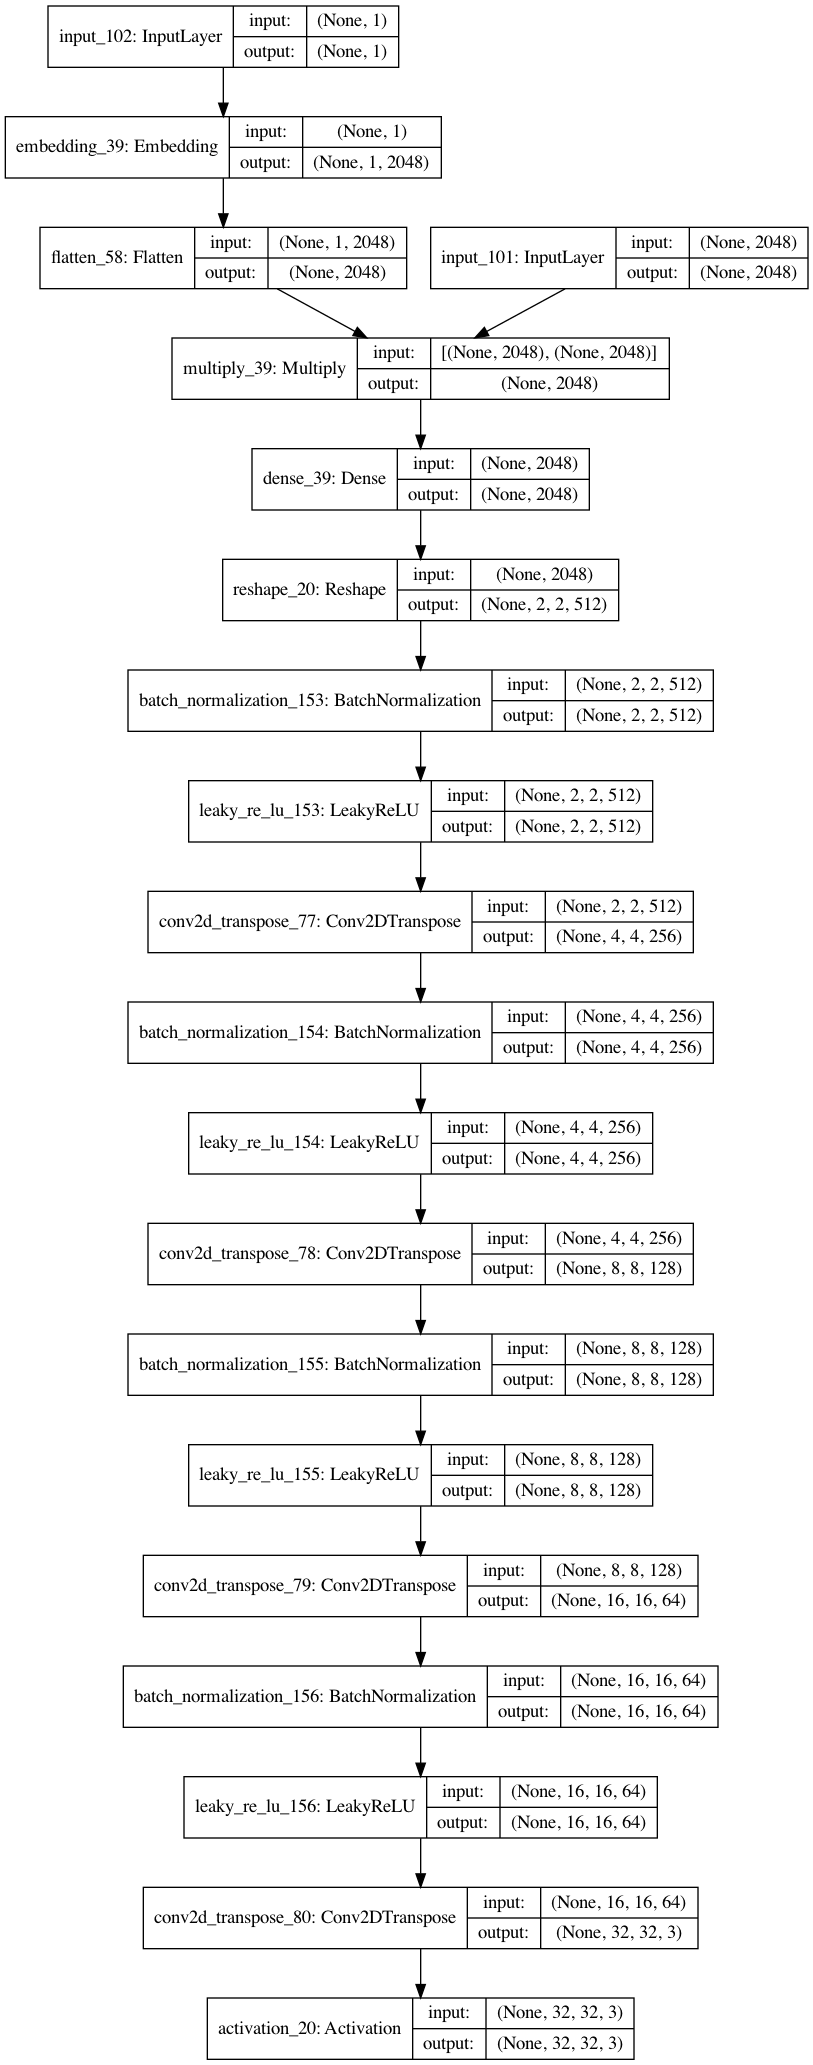

In [471]:
shp = X_train.shape[1:]
opt = Adam(lr=0.001, beta_1=0.5)
inidim_img = 2048
inidim_lbl = 1
dropout_rate = 0.3

noise = Input(shape=(noise_size, ))
label = Input(shape=(1, ))    
label_embedding = Flatten()(Embedding(classes, noise_size)(label))
model_input = multiply([noise, label_embedding])
x = Dense(2048)(model_input)
x = Reshape((2, 2, 512))(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(256, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(128, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(64, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(3, (5, 5), padding='same', strides=2)(x)
img = Activation('tanh')(x)
generator = Model([noise, label], img, name='generator')
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
generator.summary()

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Modelo para Discriminador

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
gaussian_noise_20 (GaussianNois (None, 32, 32, 3)    0           input_103[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 16, 16, 64)   1792        gaussian_noise_20[0][0]          
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 16, 16, 64)   256         conv2d_77[0][0]                  
______________________________________________________________________________________

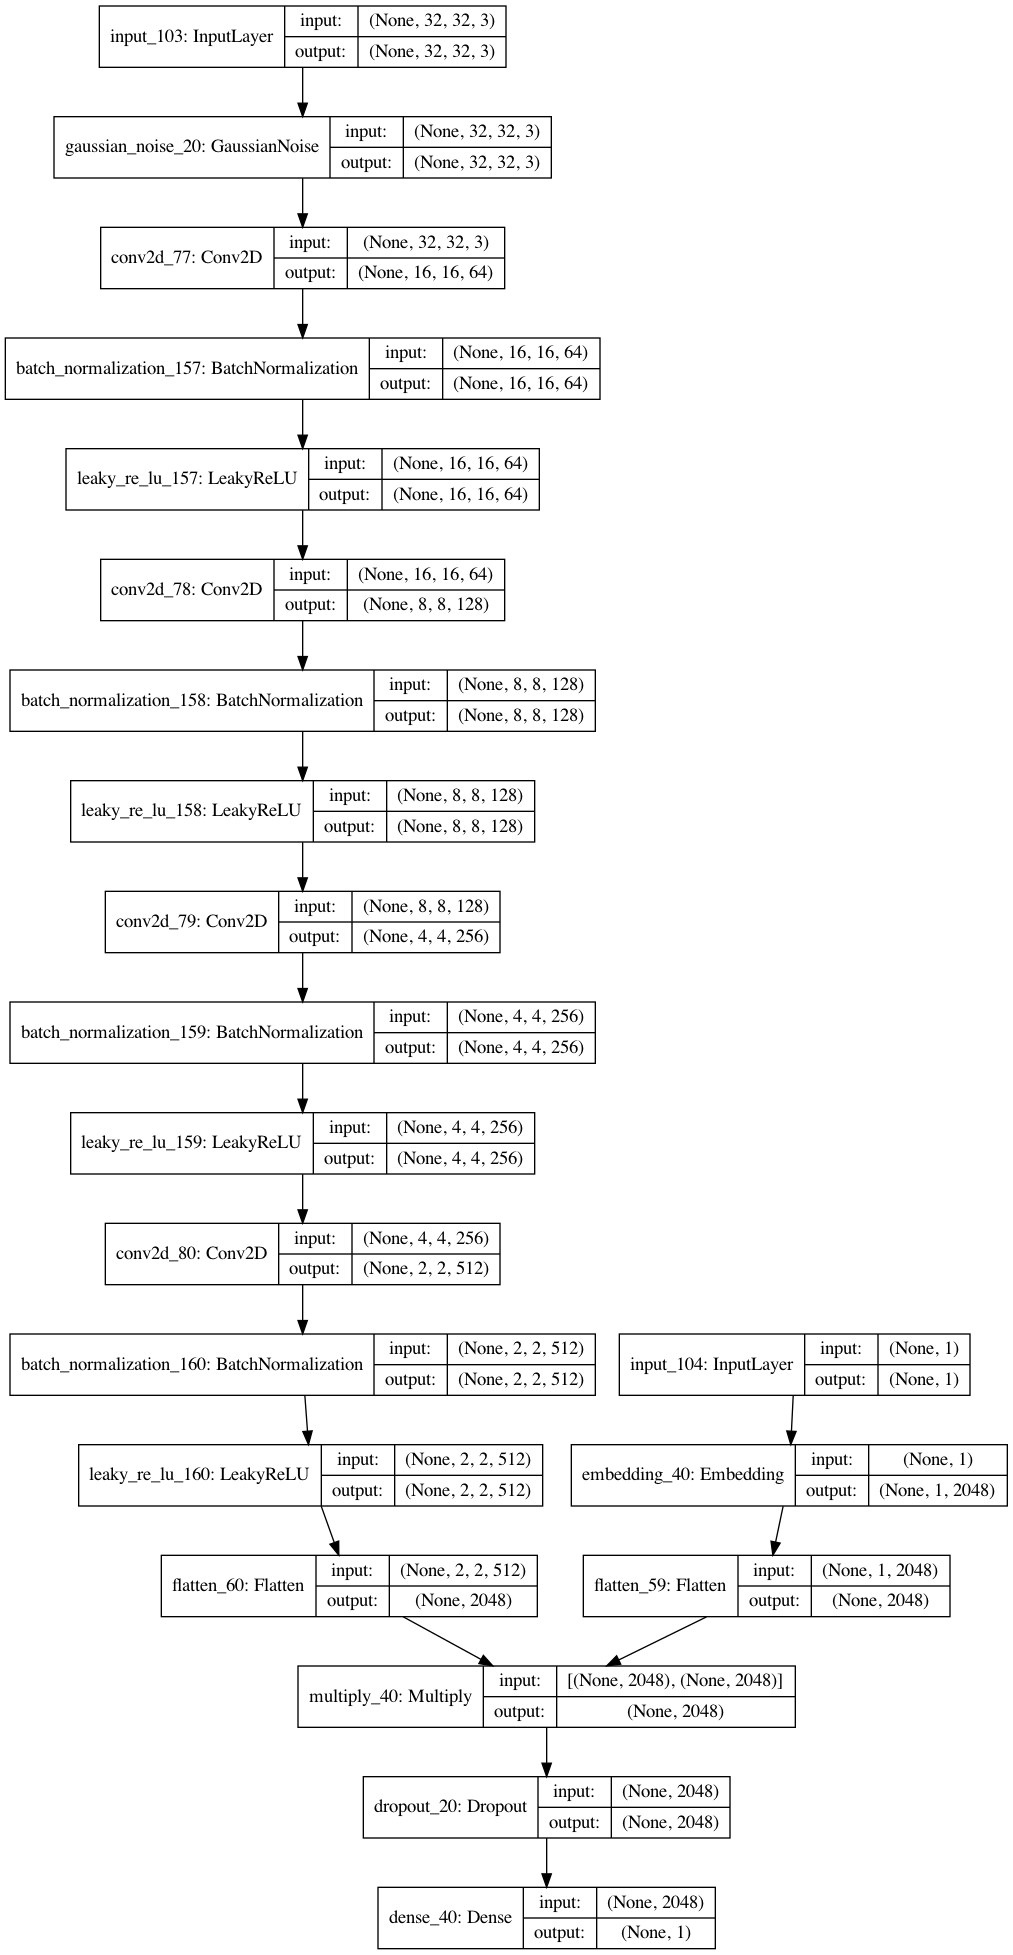

In [472]:
d_input = Input(shape=shp)
x = GaussianNoise(0.1)(d_input)
x = Conv2D(64, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(128, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(256, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(512, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
label = Input(shape=(1, ))
label_embedding = Flatten()(Embedding(classes, noise_size)(label))
flat_img = Flatten()(x)
model_input = multiply([flat_img, label_embedding])
nn = Dropout(0.3)(model_input)
validity = Dense(1, activation='sigmoid')(nn)
discriminator = Model([d_input, label], validity, name='discriminator')
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.summary()
    
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Juntar modelos de Generador y Discriminador para generar GAN

In [473]:
# Congelo los pesos del discriminador
discriminator.trainable = False

In [474]:
input_noise = Input(shape=(noise_size, ))
input_label = Input(shape=(1, ))
img = generator([input_noise, input_label])
valid = discriminator([img, input_label])

Model: "GAN Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          (None, 2048)         0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    8526723     input_105[0][0]                  
                                                                 input_106[0][0]                  
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1577345     generator[1][0]          

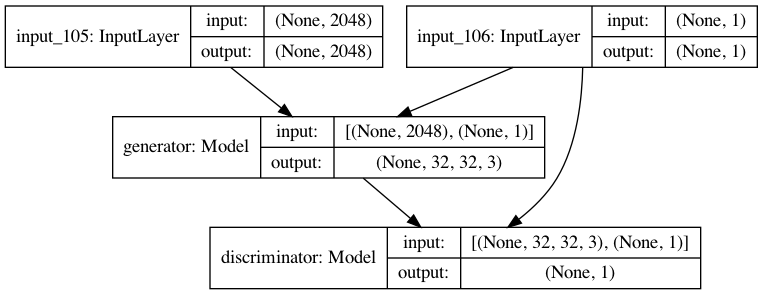

In [475]:
GAN = Model([input_noise, input_label], valid, name='GAN Model')
GAN.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=0.001, beta_1=0.5))
GAN.summary()

plot_model(GAN, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Entrenar GAN

### Pre entreno discriminador

In [476]:
# Número de iteraciones
ntrain = 6000
# Tomo datos al azar para entrenar
trainidx = np.random.choice(X_train.shape[0], ntrain)
labels_train = Y_train[trainidx]
print("labels_train", labels_train.shape)
images_train = X_train[trainidx,:,:,:]
print("images_train", images_train.shape)

# Pre-entrenar al discriminador
#Genero ruido
noise = np.random.randn(ntrain, noise_size)

#Tomo labels random
labels_sample = np.random.randint(0, 10, ntrain).reshape(-1, 1)
print("labels_sample", labels_sample.shape)

#Genero imágenes con el generador a partir del ruido
generated_images = generator.predict([noise, labels_sample])
print("images_sample", generated_images.shape)

#Junto las imágenes generadas con las originales del dataset
labels_concat = np.concatenate((labels_train, labels_sample))
images_concat = np.concatenate((images_train, generated_images))
print("labels_concat", labels_concat.shape)
print("images_concat", images_concat.shape)

#Trato de engañar al discriminador diciendo que todas las imágenes son reales
valid = np.ones((labels_concat.shape[0], 1)) - (np.random.random()*0.1)
print("valid", valid.shape)

#Permito cambiar los pesos del discriminador
discriminator.trainable = True

#Pre-entreno
discriminator.fit([images_concat, labels_concat], valid, epochs=1, batch_size=32)
#discriminator.train_on_batch([images_concat, labels_concat], valid)

labels_train (6000, 1)
images_train (6000, 32, 32, 3)
labels_sample (6000, 1)
images_sample (6000, 32, 32, 3)
labels_concat (12000, 1)
images_concat (12000, 32, 32, 3)
valid (12000, 1)


/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
12000/12000 [==============================] - 77s 6ms/step - loss: 0.1955


In [477]:
#Predigo
y_hat = discriminator.predict([images_concat, labels_concat])

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(valid,axis=1)
diff = y_idx-y_hat_idx
n_tot = valid.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 100.00 imágenes (12000 de 12000) correctas


In [89]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [478]:
# Defino un vector de pérdidas del generador y discriminador
losses = {"d":[], "g":[]}

In [494]:
def train_for_n(nb_epoch=20, plt_frq=25, BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        ########################################
        ######   GENERO IMÁGENES NUEVAS
        ########################################
        
        # Creo imágenes a partir del ruido y labels con el generador
        noise = np.random.randn(Y_train.shape[0], noise_size)
        labels_sample = Y_train[np.random.choice(Y_train.shape[0],size=BATCH_SIZE),:,:,:]  
        #labels_sample = np.random.randint(0, 10, X_train.shape[0]).reshape(-1, 1)
        generated_images = generator.predict([noise, labels_sample])
        
        ########################################
        ######   ENTRENO AL DISCRIMINADOR
        ########################################
        
        # Tomo imágenes del dataset con sus labels
        trainidx = np.random.choice(Y_train.shape[0], size=BATCH_SIZE)
        labels_batch = Y_train[trainidx]
        image_batch = X_train[trainidx,:,:,:]
        
        # Entreno al discriminador con las imágenes generadas
        #Junto imágenes generadas con imágenes del dataset original
        labels_concat = np.concatenate((labels_batch, labels_sample))
        images_concat = np.concatenate((image_batch, generated_images))
        
        #Trato de engañar al discriminador        
        valid = np.ones((labels_concat.shape[0], 1)) - (np.random.random()*0.1)
        
        #Permito entrenar al discriminador
        discriminator.trainable = True
        #Entreno
        d_loss  = discriminator.train_on_batch([images_concat, labels_concat], valid)
        #Guardo las pérdidas del discriminador
        losses["d"].append(d_loss)
    
        ########################################
        ######   ENTRENO AL GENERADOR
        ########################################
        # Congelo los pesos del discriminador para que no se modifiquen en esta parte del entrenamiento del GAN
        discriminator.trainable = False
        for i in range(1):
            noise_tr = np.random.randn(Y_train.shape[0], noise_size)
            labels_sample_tr = np.random.randint(0, 1, ntrain).reshape(-1, 1)
            # Entrenamiento
            g_loss = GAN.train_on_batch([noise_tr, labels_sample_tr])
        
        #Guardo las pérdidas del generador
        losses["g"].append(g_loss)
        
        # Actualizo las gráficas cada plt_frq iteraciones
        if e%plt_frq==0:
            plot_loss(losses)
            sample_images(e)

In [495]:
#Llamo a la función para entrenar
train_for_n(nb_epoch=5, plt_frq=25, BATCH_SIZE=128)

  0%|          | 0/5 [00:04<?, ?it/s]


IndexError: too many indices for array

## Generate sample images

In [88]:
def sample_images(epoch):
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = g_model.predict([noise, sample_label])
        
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

## Train!

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

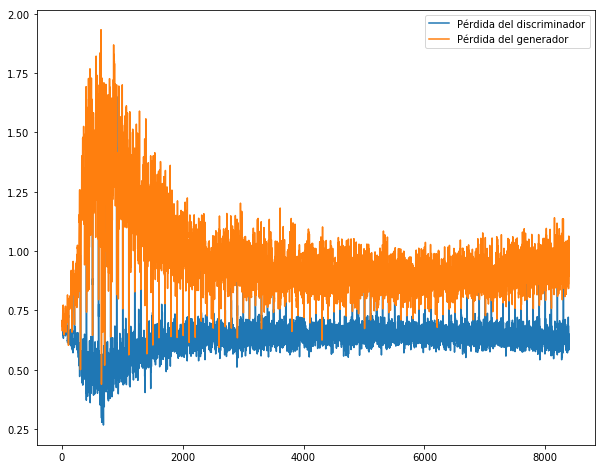

0 in range(0, 1200)
0
7 [D loss: 0.608174] [G loss: 1.061670]
1 in range(0, 1200)
2 in range(0, 1200)
3 in range(0, 1200)
4 in range(0, 1200)
5 in range(0, 1200)
6 in range(0, 1200)
7 in range(0, 1200)
8 in range(0, 1200)
9 in range(0, 1200)
10 in range(0, 1200)
11 in range(0, 1200)
12 in range(0, 1200)
13 in range(0, 1200)
14 in range(0, 1200)
15 in range(0, 1200)
16 in range(0, 1200)
17 in range(0, 1200)
18 in range(0, 1200)
19 in range(0, 1200)
20 in range(0, 1200)
21 in range(0, 1200)
22 in range(0, 1200)
23 in range(0, 1200)
24 in range(0, 1200)
25 in range(0, 1200)
26 in range(0, 1200)
27 in range(0, 1200)
28 in range(0, 1200)
29 in range(0, 1200)
30 in range(0, 1200)
31 in range(0, 1200)
32 in range(0, 1200)
33 in range(0, 1200)
34 in range(0, 1200)
35 in range(0, 1200)
36 in range(0, 1200)
37 in range(0, 1200)
38 in range(0, 1200)
39 in range(0, 1200)
40 in range(0, 1200)
41 in range(0, 1200)
42 in range(0, 1200)
43 in range(0, 1200)
44 in range(0, 1200)
45 in range(0, 1200)
46

362 in range(0, 1200)
363 in range(0, 1200)
364 in range(0, 1200)
365 in range(0, 1200)
366 in range(0, 1200)
367 in range(0, 1200)
368 in range(0, 1200)
369 in range(0, 1200)
370 in range(0, 1200)
371 in range(0, 1200)
372 in range(0, 1200)
373 in range(0, 1200)
374 in range(0, 1200)
375 in range(0, 1200)
376 in range(0, 1200)
377 in range(0, 1200)
378 in range(0, 1200)
379 in range(0, 1200)
380 in range(0, 1200)
381 in range(0, 1200)
382 in range(0, 1200)
383 in range(0, 1200)
384 in range(0, 1200)
385 in range(0, 1200)
386 in range(0, 1200)
387 in range(0, 1200)
388 in range(0, 1200)
389 in range(0, 1200)
390 in range(0, 1200)
391 in range(0, 1200)
392 in range(0, 1200)
393 in range(0, 1200)
394 in range(0, 1200)
395 in range(0, 1200)
396 in range(0, 1200)
397 in range(0, 1200)
398 in range(0, 1200)
399 in range(0, 1200)
400 in range(0, 1200)
400
7 [D loss: 0.670665] [G loss: 0.913828]
401 in range(0, 1200)
402 in range(0, 1200)
403 in range(0, 1200)
404 in range(0, 1200)
405 in ran

In [ ]:
train(epochs=20)

In [421]:
def predict_random():
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = GAN.predict([noise, sample_label])
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            #axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].set_title(labels[sample_label[cnt][0]])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()        
    plt.close()

(10, 1)


ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1,)

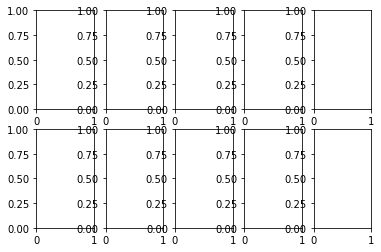

In [422]:
predict_random()

In [96]:
def predict_one(label=0):
    noise = np.random.randn(1, noise_size)
    sample_label = np.arange(0, 1).reshape(-1, 1)
    gen_img = g_model.predict([noise, sample_label])
    img = image.array_to_img(gen_img[label])
    plt.imshow(img)
    print(labels[sample_label[label][0]])
    plt.axis('off')
    plt.show()        
    plt.close()

Airplane


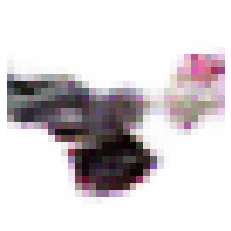

In [97]:
predict_one()